In [45]:
from differentiable_t1d.dynamics import KanderianMvpParams, KanderianMvp, kanderian_mvp
from differentiable_t1d.utils import generate_meals
from differentiable_t1d.controls import square_profile, two_equal_compartment_profile, make_sequential_profile


import jax
import jax.numpy as jnp
import numpy as np
dynamics_params, init_state = kanderian_mvp.initialize_patient(1, to_tensors=False)
""" 
To simulate a new patient, calibrate the basal insulin rate and the insulin sensitivity factor.
1. Simulate patient with no boluses. Find basal insulin rate that keeps blood glucose close to target range
2. Use steadystate state as the initial condition for future runs.
3. Adjust insulin sensitivity factor to make it look reasonable.
Right now everything is calibrated for patient 1
"""

In [46]:
from differentiable_t1d.controls import BolusParams, BolusController

In [90]:
seed = 0
rng = jax.random.PRNGKey(seed)

t0 = jnp.array(0.)
num_days = 7 
t1 = 60. * 24 * num_days # 24 hours in minutes
dt = 1.0   # IMPORANT: this can't be too large or else the integration will diverge (ex when t=5.)
T = int((t1 - t0) / dt) + 1

bolus_params = BolusParams(insulin_carb_ratio=20., correction_factor=35., target_bg=140., prebolus_time=15.)
basal_rate = 0.04 # U/min

meals = generate_meals(bw=dynamics_params.BW.item(), num_days=num_days, seed=0)

meal_times = meals[:, 0]  # minutes
carb_amounts = meals[:, 1]  # g
meal_dose = carb_amounts # g
# convert to mg
meal_dose = meal_dose * 1000.0
# convert to mg/dL
meal_dose = meal_dose / dynamics_params.vg
tau_m = jnp.exp(4 + 0.5 * jax.random.normal(rng, meal_dose.shape))
meal_k = 1 / tau_m  # 1/min

In [91]:
%%time


def step(t, state, doses):
    bg = KanderianMvp.observe_subcutaneous_glucose(dynamics_params, state)
    dose = BolusController.apply(bolus_params, meal_times, carb_amounts, t, dt, bg)
    doses = jnp.concatenate([doses, jnp.array([[t, dose]])], axis=0)

    # meal computations doesn't change so we can compute it outside of the loop
    meal_profile = make_sequential_profile(two_equal_compartment_profile, (meal_dose, meal_k), meal_times)

    insulin_times = doses[:, 0]
    insulin_duration = dt * jnp.ones_like(insulin_times)
    insulin_doses = doses[:, 1]
    insulin_profile = make_sequential_profile(square_profile, (insulin_doses, insulin_duration), insulin_times)

    # compute meal and insulin rate curves
    carbs = meal_profile(t)
    insulin = insulin_profile(t)
    # add basal dose; more generally, we could instead have another control function for basal dosing
    insulin = insulin + basal_rate * dt
    # convert U to an insulin delivery rate muU / mL / min
    insulin = insulin * 1e6 / dynamics_params.ci / dynamics_params.tau1
    dstate_dt, _ = KanderianMvp.dynamics(dynamics_params, t, state, carbs, insulin)
    state = state + dstate_dt * dt
    return state, dose, doses

def step_wrapped(carry, i):
    state, doses = carry
    t = t0 + i * dt
    state, dose, doses = step(t, state, doses)
    return (state, jax.lax.slice_in_dim(doses, doses.shape[0] - k, doses.shape[0])), (t, dose, state)

k = int(4 * 60. / dt) # jax.jit requires a fixed shape input to avoid recompilation
doses_arr = jnp.zeros((k, 2))

init_carry = (init_state, doses_arr)
timesteps = jnp.arange(1, T)
_, (ts, doses, states) = jax.lax.scan(step_wrapped, init_carry, timesteps)

states = jnp.concatenate([init_state[None, :], states], axis=0)
ts = jnp.concatenate([jnp.array([t0]), ts], axis=0)
doses = jnp.concatenate([jnp.zeros((1,)), doses], axis=0)

CPU times: user 182 ms, sys: 183 µs, total: 182 ms
Wall time: 180 ms


In [92]:
G, Ieff, Isc, Ip, Gisf = states.T

[Text(0, 0.5, 'Gisf')]

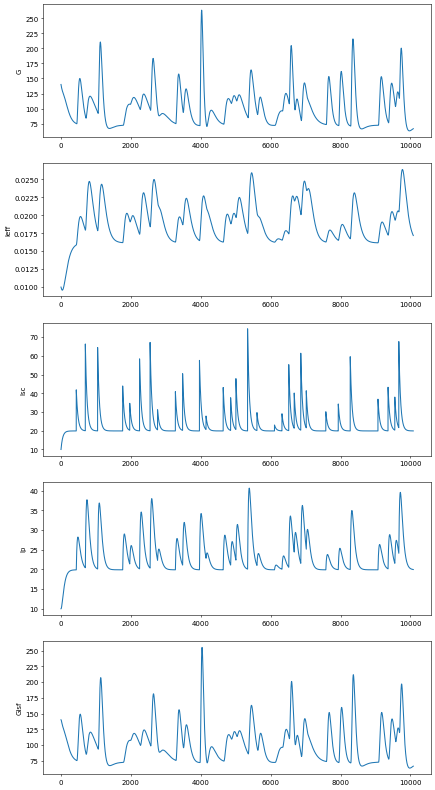

In [93]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 1, figsize=(10, 20), dpi=50)
ax[0].plot(G)
ax[0].set(ylabel="G")
ax[1].plot(Ieff)
ax[1].set(ylabel="Ieff")
ax[2].plot(Isc)
ax[2].set(ylabel="Isc")
ax[3].plot(Ip)
ax[3].set(ylabel="Ip")
ax[4].plot(Gisf)
ax[4].set(ylabel="Gisf")



In [94]:
nonzero = doses.nonzero()[0]
insulin_doses = doses[nonzero]
insulin_times = ts[nonzero]

[Text(0.5, 0, 'Time (hr)'), Text(0, 0.5, 'Glucose (mg/dL)')]

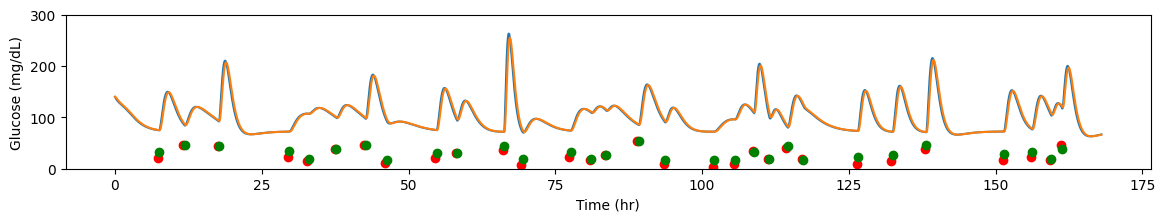

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
t = np.arange(T) * dt
G = KanderianMvp.observe_blood_glucose(dynamics_params, states)
Gs = KanderianMvp.observe_subcutaneous_glucose(dynamics_params, states)
ax.plot(t / 60, G)
ax.plot(t / 60, Gisf)
ax.plot(insulin_times / 60, insulin_doses * 10, 'o', color="red")
ax.plot(meal_times / 60, meal_dose * 0.1, 'o', color="green")
ax.set(ylim=[0, 300])
ax.set(xlabel="Time (hr)", ylabel="Glucose (mg/dL)")

[(0.0, 300.0)]

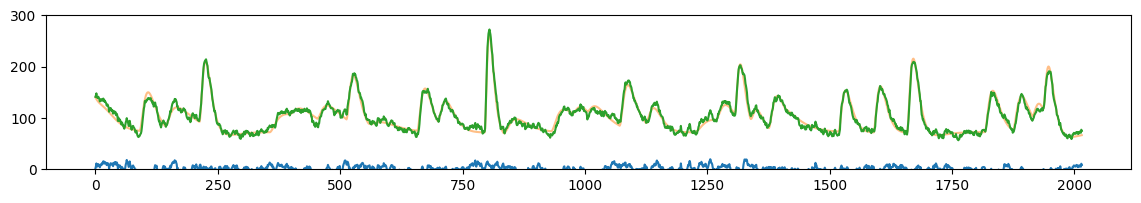

In [96]:
# try adding autoregressive noise similar to what you might get from a CGM
# also subsample to be every 5 mins

noise = jax.random.normal(jax.random.PRNGKey(0), (len(G) // 5,)) * 3 
noise = np.array(noise)
for i in range(1, len(noise)):
    noise[i] = noise[i] + 0.9 * noise[i - 1]

fig, ax = plt.subplots(1, 1, figsize=(14, 2))

noisy_G = np.array(noise.copy())
G_subsampled = np.array(noise.copy())
for i in range(len(noisy_G)):
    noisy_G[i] = noisy_G[i] + G[i * 5]
    G_subsampled[i] = G[i * 5]

ax.plot(noise)
ax.plot(G_subsampled, alpha=0.5)
ax.plot(noisy_G)
ax.set(ylim=[0, 300])
#ax.set(xlim=[256, 256 * 2])